In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import cross_validate
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier

from genreclassification.utils import get_project_root

import dataframe_image as dfi
pd.set_option("display.max_columns", None)

# classical ML algs: random forest

## pre-processing

In [2]:
df_30 = pd.read_csv(
    get_project_root() / "data/features_30_sec.csv"
)

df_3 = pd.read_csv(
    get_project_root() / "data/features_3_sec.csv"
)

### features / targets:

In [3]:
# get the target labels:
df_3_y = df_3["label"]

# find the training features:
df_3_x = df_3.drop(
    columns=["filename", "length", "label"]
)

### test split before scaling:

In [4]:
x_train, x_test, y_train, y_test = train_test_split(
    df_3_x,
    df_3_y,
    test_size=0.2,
    random_state=42
)

### MinMax scaling for the training set:

In [5]:
scaler = MinMaxScaler((0,1))
# scale fetures and get column names
scale_cols = x_train.columns
x_scaled = scaler.fit_transform(x_train[scale_cols])
# retrieve column names for scaled df:
x_train_scaled = pd.DataFrame(
    x_scaled,
    columns=scale_cols
)


## ML metrics

In [6]:
def cv_model(model, x, y, name):
    df = pd.DataFrame(
        cross_validate(
            model,
            x,
            y,
            cv=10,
            scoring=[
                "accuracy",
                # "recall",
                # "precision",
                # "f1_weighted",
                # "roc_auc"
            ]
        )
    )
    
    df = df.mean().to_frame().transpose()
    df.rename(index={0:f"{name}"}, inplace=True)

    return df

## random forest

In [7]:
rf = RandomForestClassifier(random_state=42)

In [8]:
cv_model(rf, x_train_scaled, y_train, "randomforest")

,fit_time,score_time,test_accuracy
randomforest,3.891913,0.029559,0.859235


In [9]:
type(rf)

sklearn.ensemble._forest.RandomForestClassifier

In [10]:
rf.fit(x_train_scaled, y_train)

RandomForestClassifier(random_state=42)

In [11]:
type(rf)

sklearn.ensemble._forest.RandomForestClassifier

---
## feature importance

In [27]:
importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)

forest_importances = pd.Series(importances, index=x_train.columns, name="importance")
forest_std = pd.Series(std, index=x_train.columns, name="std")

df = pd.concat(
    [forest_importances, forest_std],
    axis=1
)

In [37]:
df.sort_values(by="importance", inplace=True)

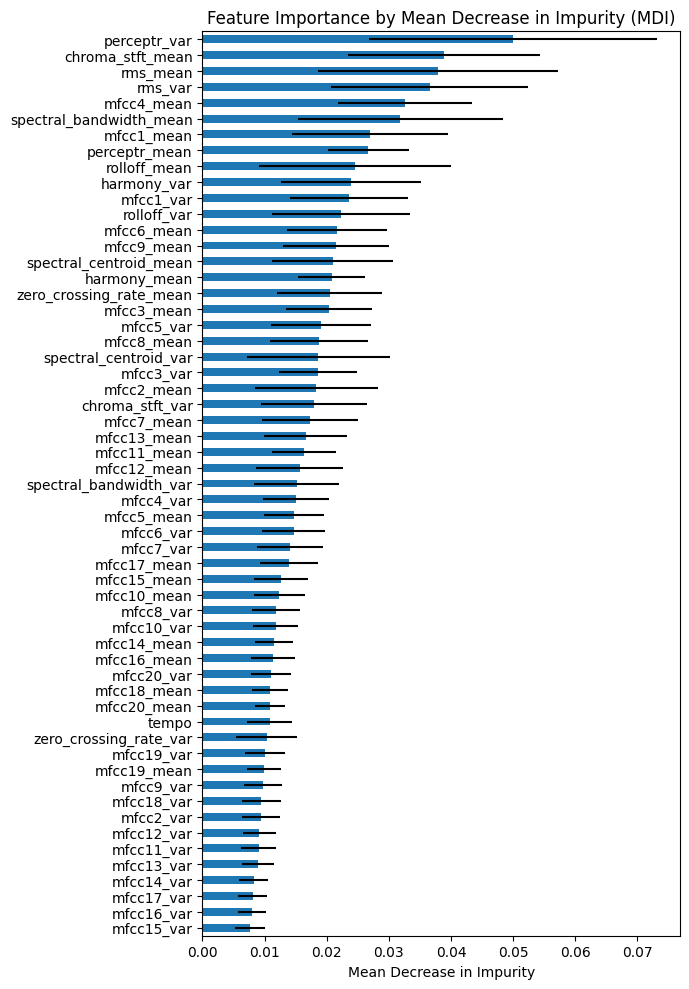

In [42]:
fig = plt.figure(figsize=(7,10))
ax = fig.add_subplot(111)
ax.set_title("Feature Importance by Mean Decrease in Impurity (MDI)")
df["importance"].plot.barh(xerr=df["std"], ax=ax)
ax.set_xlabel("Mean Decrease in Impurity")
fig.tight_layout()

In [43]:
fig.savefig(
    get_project_root() / "output/rf/feat_imp.png"
)

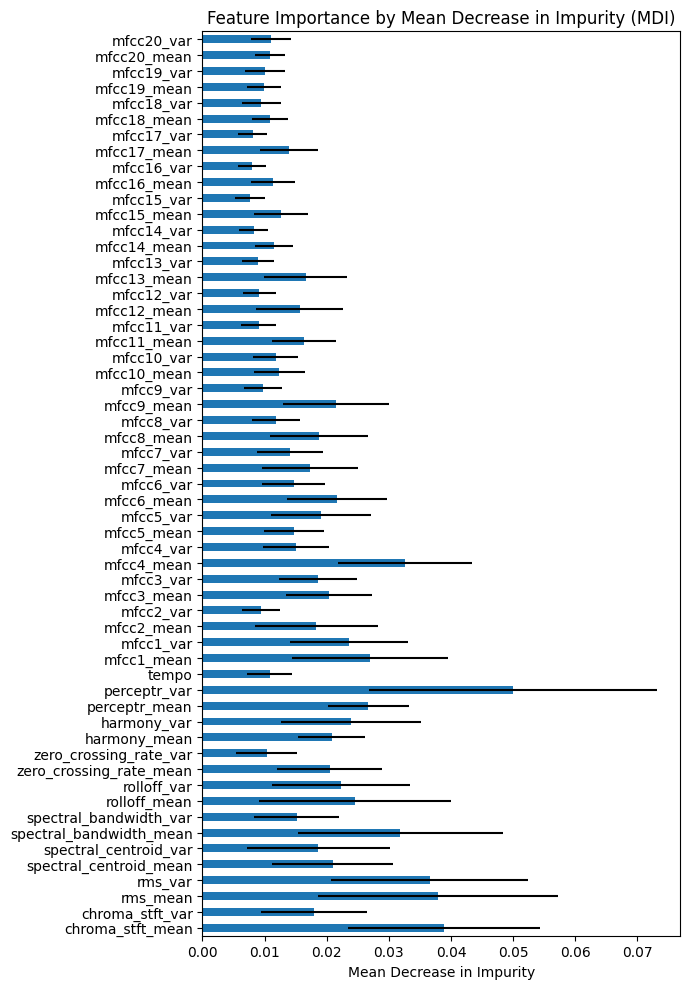

In [40]:
fig = plt.figure(figsize=(7,10))
ax = fig.add_subplot(111)
ax.set_title("Feature Importance by Mean Decrease in Impurity (MDI)")
forest_importances.plot.barh(xerr=std, ax=ax)
ax.set_xlabel("Mean Decrease in Impurity")
fig.tight_layout()

---

In [12]:
# return metrics for the multiclass classification
rf_cv = cross_validate(
    rf,
    x_train_scaled,
    y_train,
    cv=10,
    scoring=[
        "accuracy",
        "f1_micro",
        "f1_macro",
        "precision_micro",
        "precision_macro",
        "recall_micro",
        "recall_macro"
    ]
)

In [13]:
rf_val_scores = pd.DataFrame(
    rf_cv,
    index=rf.classes_,
)
rf_val_scores.columns = rf_val_scores.columns.str.strip("test_")
rf_val_scores.drop(columns=["fit_tim", "core_tim"], inplace=True)
rf_val_scores = rf_val_scores.transpose()
rf_val_scores["average"] = rf_val_scores.mean(axis=1)
rf_val_scores

,blues,classical,country,disco,hiphop,jazz,metal,pop,reggae,rock,average
accuracy,0.866250,0.846250,0.856070,0.856070,0.867334,0.854819,0.868586,0.864831,0.846058,0.866083,0.859235
f1_micro,0.866250,0.846250,0.856070,0.856070,0.867334,0.854819,0.868586,0.864831,0.846058,0.866083,0.859235
f1_macro,0.865747,0.845972,0.854752,0.854656,0.866607,0.854397,0.867391,0.863812,0.845964,0.866280,0.858558
precision_micro,0.866250,0.846250,0.856070,0.856070,0.867334,0.854819,0.868586,0.864831,0.846058,0.866083,0.859235
precision_macro,0.867397,0.848259,0.858103,0.858537,0.868799,0.855950,0.870857,0.867610,0.850051,0.868298,0.861386
recall_micro,0.866250,0.846250,0.856070,0.856070,0.867334,0.854819,0.868586,0.864831,0.846058,0.866083,0.859235
recall_macro,0.866346,0.845976,0.856088,0.856290,0.867302,0.855004,0.868728,0.864945,0.846285,0.866303,0.859327


## model prediction

In [14]:
# scale the x_test with the same scaler as used on the training set:
scale_cols = x_test.columns
x_test_scaled = scaler.transform(x_test[scale_cols])
# retrieve column names for scaled df:
x_test_scaled = pd.DataFrame(
    x_test_scaled,
    columns=scale_cols
)

In [15]:
pred = rf.predict(x_test_scaled)

In [16]:
pred

array(['reggae', 'jazz', 'blues', ..., 'hiphop', 'disco', 'reggae'],
      dtype=object)

In [17]:
cm = confusion_matrix(
    y_test,
    pred
)
cm

array([[176,   1,  13,   3,   1,   7,   3,   0,   3,   1],
       [  0, 199,   0,   0,   0,   3,   0,   0,   0,   1],
       [ 17,   0, 147,   3,   1,  11,   1,   2,   2,   2],
       [  1,   2,   3, 169,   6,   3,   2,   3,   3,   7],
       [  4,   1,   4,   2, 193,   1,   5,   5,   2,   1],
       [  2,  11,   3,   1,   0, 175,   0,   0,   0,   0],
       [  0,   0,   1,   1,   1,   0, 193,   0,   2,   6],
       [  0,   0,   3,   2,   2,   0,   0, 166,   4,   3],
       [  3,   1,   7,   5,   5,   1,   2,   6, 180,   1],
       [  3,   1,  15,  10,   1,   6,   8,   0,   6, 147]])

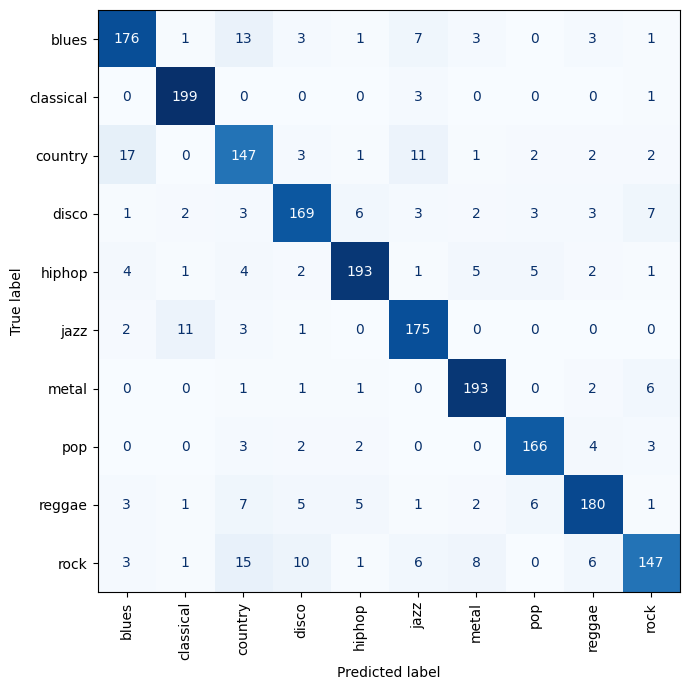

In [18]:
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111)
ConfusionMatrixDisplay(
    cm,
    display_labels=rf.classes_
).plot(
    xticks_rotation=90,
    cmap="Blues",
    colorbar=False,
    ax=ax
)
fig.tight_layout()

In [19]:
fig.savefig(
    get_project_root() / "output/rf/rf_test_cm.svg"
)
fig.savefig(
    get_project_root() / "output/rf/rf_test_cm.png"
)

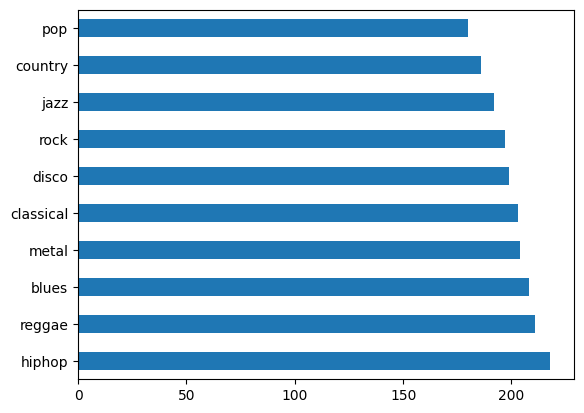

In [20]:
y_test.value_counts().plot(kind="barh");

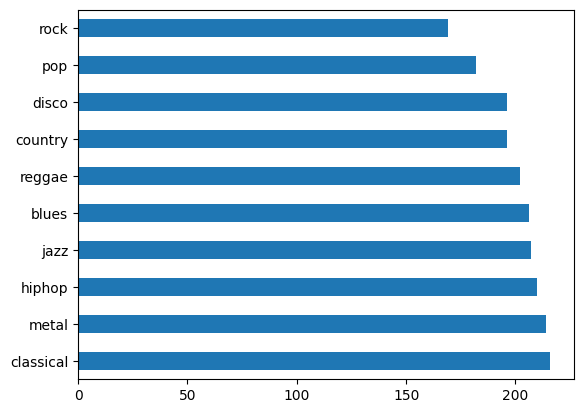

In [21]:
pd.Series(pred).value_counts().plot(kind="barh");

In [22]:
def average_metrics(y_test, y_pred):
    scorers = {
        "accuracy": accuracy_score(y_test, y_pred),
        "f1_micro": f1_score(y_test, y_pred, average="micro"),
        "f1_macro": f1_score(y_test, y_pred, average="macro"),
        "recall_micro": recall_score(y_test, y_pred, average="micro"),
        "recall_macro": recall_score(y_test, y_pred, average="macro"),
        "precision_micro": precision_score(y_test, y_pred, average="micro"),
        "precision_macro": precision_score(y_test, y_pred, average="macro")
    }
    df = pd.DataFrame(index=scorers.keys(), columns=["metric score"])
    for scorer in scorers.keys():
        df.at[scorer, "metric score"] = scorers[scorer]
    df=df.transpose()
    return df

In [39]:
rf_metrics = average_metrics(y_test, pred)
rf_metrics

,accuracy,f1_micro,f1_macro,recall_micro,recall_macro,precision_micro,precision_macro
metric score,0.873373,0.873373,0.872004,0.873373,0.873037,0.873373,0.872724


In [30]:
dfi.export(
    rf_metrics,
    "../output/rf/rf_average_metrics.png"
)

[0109/170352.265724:INFO:headless_shell.cc(623)] Written to file /var/folders/ng/4x8hyf_s39b2rqzs184hl_lr0000gp/T/tmpy_ylesst/temp.png.


In [40]:
rf_metrics_t = rf_metrics.transpose()
dfi.export(
    rf_metrics_t,
    "../output/rf/rf_average_metrics_t.png"
)

[0109/172117.231572:INFO:headless_shell.cc(623)] Written to file /var/folders/ng/4x8hyf_s39b2rqzs184hl_lr0000gp/T/tmpezj7rq6_/temp.png.


In [31]:
def class_metrics(y_test, y_pred, class_labels):
    df = pd.DataFrame(index=rf.classes_)

    for scorer in [
        ("recall", recall_score),
        ("precision", precision_score),
        ("f1", f1_score)
    ]:
        metric_score = scorer[1](
            y_test,
            y_pred,
            average=None,
            labels=class_labels
        )
        df[scorer[0]] = metric_score

    df = df.transpose()

    return df

In [41]:
c_metrics = class_metrics(y_test, pred, rf.classes_)
c_metrics

,blues,classical,country,disco,hiphop,jazz,metal,pop,reggae,rock
recall,0.846154,0.980296,0.790323,0.849246,0.885321,0.911458,0.946078,0.922222,0.853081,0.746193
precision,0.854369,0.921296,0.750000,0.862245,0.919048,0.845411,0.901869,0.912088,0.891089,0.869822
f1,0.850242,0.949881,0.769634,0.855696,0.901869,0.877193,0.923445,0.917127,0.871671,0.803279


In [33]:
dfi.export(
    c_metrics,
    "../output/rf/rf_class_metrics.png"
)

[0109/170418.146649:INFO:headless_shell.cc(623)] Written to file /var/folders/ng/4x8hyf_s39b2rqzs184hl_lr0000gp/T/tmpt2qk9ojv/temp.png.


In [42]:
c_metrics_t = c_metrics.transpose()
dfi.export(
    c_metrics_t,
    "../output/rf/rf_class_metrics_t.png"
)

[0109/172219.356493:INFO:headless_shell.cc(623)] Written to file /var/folders/ng/4x8hyf_s39b2rqzs184hl_lr0000gp/T/tmprf0_kq5k/temp.png.
